In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from scipy import signal
from stingray import lightcurve
import sys
from stingray import Bispectrum
import warnings
import csv
import random
warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\farra\anaconda3\envs\eeg_env\lib\site-packages\stingray\utils.py:54: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


## FFT Function Definition

In [2]:
def calculateFft(data, sample_rate):
    fft = np.fft.fft(data, axis=0)
    fft_freq = np.fft.fftfreq(len(data), d=1.0/sample_rate)
    return np.abs(fft), np.abs(fft_freq)


In [3]:
# def bandpass_filter(data, lowcut, highcut, fs, order=2):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = scipy.signal.butter(order, [low, high], btype='band')
#     y = scipy.signal.filtfilt(b, a, data, axis=0)
#     return y

In [4]:
def extract_band_power(fft_values, freq, band):
    band_freq_indices = np.where((freq >= band[0]) & (freq <= band[1]))[0]
    band_power = np.mean(np.abs(fft_values[band_freq_indices, :]) ** 2, axis=0)
    return band_power

In [5]:
def calculateBandPower(fft_result, fft_freq, bands, channel_name):
    band_powers = {}
    for band_name, band_range in bands.items():
        band_powers[band_name] = extract_band_power(fft_result, fft_freq, band_range)

    band_powers_df = pd.DataFrame(band_powers, index=channel_name)
    band_powers_np = band_powers_df.values
    return band_powers_np

In [11]:
def calcRelativeEnergy(band_powers):
    # Calculate relative energy
    total_energy = np.sum(band_powers)
    relative_energies = [(e / total_energy) * 100 for e in band_powers]

    return relative_energies

In [8]:
def get_csv_EEG(filename):
    # Load data from CSV
    df_data = pd.read_csv(filename)
    return df_data, df_data.columns

def get_dummy(directory):
    names = random.choice(os.listdir(directory))
    files = os.listdir(os.path.join(directory, names))
    # Take random sample file in the folder
    rel_path = os.path.join(directory, names, random.choice(files))
    print(rel_path)
    df_data = pd.read_csv(rel_path)
    return df_data

In [18]:
# Test FFT 
SAMPLING_RATE = 256
df = get_dummy("datasets/segmented_1 seconds/autism")
data = df.values

fft_result, fft_freq = calculateFft(data, SAMPLING_RATE)

datasets/segmented_1 seconds/autism\Mohammed\segment_611.csv


In [19]:
bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 60)}

In [20]:
band_powers_np = calculateBandPower(fft_result, fft_freq, bands, df.columns)

In [21]:
fff = calcRelativeEnergy(band_powers_np.flatten())

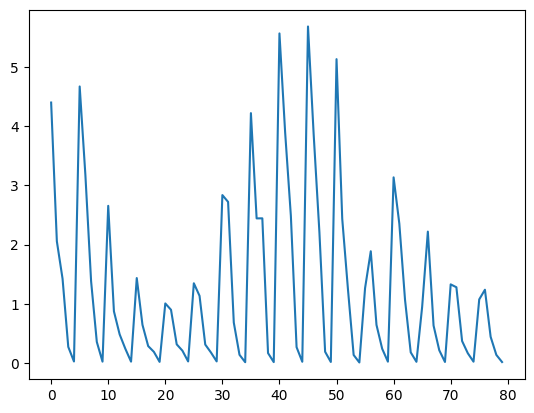

In [22]:
plt.figure()
plt.plot(range(len(fff)), fff)
plt.show()

## FFT Feature Extraction

In [23]:
def extract_feature(directory, destination, segment_time=1):
    bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 60)}

    recap = pd.DataFrame(columns=['Wall Time', 'CPU Time'])
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            des_dir = os.path.join(destination +"_" , foldername).lower()
            files = os.listdir(folder)
            for filename in files:
                # print(f"Extract feature from {filename}...")
                cpu_start = time.process_time()
                wt_start = time.time()
                # if filename in zeros_train or filename in zeros_test:
                #     continue
                rel_path = os.path.join(directory, foldername, filename)
                # if 'metadata' in filename.lower():
                #     continue
                # trial_number = filename.split('.')[0].split('_')[1]
                df_data, channel_name = get_csv_EEG(rel_path)
                des_file = foldername +'_'+ filename + '_fft_rel' +'.npy'
                if not os.path.exists(des_dir):
                    os.makedirs(des_dir)
                des_path = os.path.join(des_dir, des_file)
                if os.path.exists(des_path):
                    continue
                

                fft_result, fft_freq = calculateFft(df_data.values, SAMPLING_RATE)

                band_powers = {}
                for band_name, band_range in bands.items():
                    band_powers[band_name] = extract_band_power(fft_result, fft_freq, band_range)

                band_powers_df = pd.DataFrame(band_powers, index=channel_name)
            
                FFT = calcRelativeEnergy(band_powers_df.values.flatten())
                np.save(des_path, FFT)
                wt_end = time.time()
                cpu_end = time.process_time()
                wall_time = wt_end - wt_start
                cpu_time = cpu_end - cpu_start
                recap_temp = pd.DataFrame([[wall_time, cpu_time]],columns=recap.columns)
                recap = pd.concat([recap, recap_temp], ignore_index=True)
                # print(f"CPU Time: {cpu_time}, Wall Time: {wall_time}")
                # pd.DataFrame(FFT.T).to_csv(des_path, index=False)
    recap_dir = os.path.join('./logs/Execution',directory.split('/')[1])
    if not os.path.exists(recap_dir):
        os.makedirs(recap_dir)
    recap_path = os.path.join(recap_dir,'recap_fft_rel'+'.csv')
    recap.to_csv(recap_path)


## Main Program

In [12]:
SEGMENT_TIME = 1

directory_segmented = f"datasets/segmented_{SEGMENT_TIME} seconds"
directory_feature = f"datasets/features/FFT_relative/segment_{SEGMENT_TIME} seconds"
directory_logs = f"logs/Execution/segmented_{SEGMENT_TIME} seconds"

In [13]:
extract_feature(os.path.join(directory_segmented, "autism"), os.path.join(directory_feature, "autism"), segment_time=SEGMENT_TIME)
extract_feature(os.path.join(directory_segmented, "normal"), os.path.join(directory_feature, "normal"), segment_time=SEGMENT_TIME)